In [1]:
import pandas as pd
from transformers import pipeline
from sklearn.metrics import accuracy_score, classification_report
from datasets import Dataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import os,sys
config_path = os.path.abspath(os.path.join(os.getcwd(), '..','..', 'Loading_Database'))
sys.path.append(config_path)
from configuration import *


In [33]:
base_dir = os.path.abspath(os.path.join(os.getcwd()))  # Go one level up 

# Load 14k manually labelled tweets public dataset that has been translated via DeepL cloud translation API
file_path_14k = os.path.join(base_dir, "testing_datasets", "translated_airline_tweets_70pct_dutch.csv")
df_14k = pd.read_csv(file_path_14k)
df_14k["translated_text"] = df_14k["translated_text"].fillna(df_14k["text"])
df_14k = df_14k.rename(columns={"airline_sentiment": "manual_label"})
df_14k["manual_label"] = df_14k["manual_label"].str.lower()
sa_dataset = Dataset.from_pandas(df_14k)

# Load our own 100 manually labelled tweets from the database
file_path_100_own = os.path.join(base_dir, "testing_datasets", "Manual_check_full_text.csv")
df_100_own = pd.read_csv(file_path_100_own, encoding='cp1252')
df_100_own[['full_text', 'label']] = df_100_own[["full_text", "label"]].astype('string')

In [34]:
df_100_own.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         100 non-null    int64 
 1   full_text  100 non-null    string
 2   label      100 non-null    string
dtypes: int64(1), string(2)
memory usage: 2.5 KB


In [5]:
model_cardiff = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment")
model_tabularis = pipeline("sentiment-analysis", model="tabularisai/multilingual-sentiment-analysis")

Device set to use cuda:0
Device set to use cuda:0


In [36]:
# Applying sentiment models to test datasets:
# cardiff_results_14k = model_cardiff(sa_dataset["translated_text"], batch_size=32)
# tabularis_results_14k = model_tabularis(sa_dataset["translated_text"], batch_size=32)

cardiff_results_100_own = model_cardiff(df_100_own["full_text"].tolist(), batch_size=32)
tabularis_results_100_own = model_tabularis(df_100_own["full_text"].tolist(), batch_size=32)


In [7]:
# Map CardiffNLP labels
cardiff_label_map = {
    "LABEL_0": "negative",
    "LABEL_1": "neutral",
    "LABEL_2": "positive"
}

# Clean result outputs
def parse_cardiff(r):
    return cardiff_label_map.get(r["label"], None)

def parse_tabularis(r):
    label = r["label"].lower()
    if "pos" in label: return "positive"
    if "neg" in label: return "negative"
    return "neutral"


In [ ]:
df_14k["pred_cardiff"] = [parse_cardiff(r) for r in cardiff_results_14k]
df_14k["pred_tabularis"] = [parse_tabularis(r) for r in tabularis_results_14k]
df_14k.head()

,tweet_id,text,manual_label,target_lang,translated_text,pred_cardiff,pred_tabularis
0,570306133677760513,@VirginAmerica What @dhepburn said.,neutral,NL,@VirginAmerica Wat @dhepburn zei.,neutral,positive
1,570301130888122368,@VirginAmerica plus you've added commercials t...,positive,ES,@VirginAmerica además has añadido anuncios a l...,neutral,negative
2,570301083672813571,@VirginAmerica I didn't today... Must mean I n...,neutral,NL,@VirginAmerica Vandaag niet... Moet betekenen ...,neutral,negative
3,570301031407624196,@VirginAmerica it's really aggressive to blast...,negative,NL,@VirginAmerica het is echt agressief om aansto...,neutral,negative
4,570300817074462722,@VirginAmerica and it's a really big bad thing...,negative,DE,@VirginAmerica und es ist eine wirklich große ...,neutral,negative


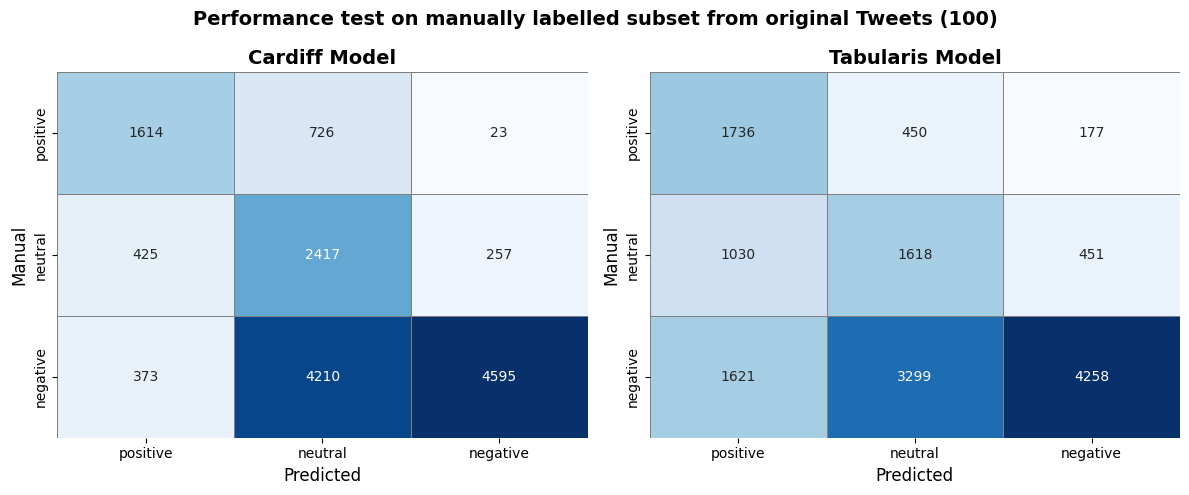

In [ ]:
### BASIC COMPARISON HEATMAPS ###


labels = ['positive', 'neutral', 'negative']

# === Confusion Matrices ===
cm_cardiff = confusion_matrix(df_14k['manual_label'], df_14k['pred_cardiff'], labels=labels)
cm_tabularis = confusion_matrix(df_14k['manual_label'], df_14k['pred_tabularis'], labels=labels)

# === Plot Function ===
def plot_side_by_side_confusion_matrices(cm1, cm2, labels, title1, title2, main_title):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    plt.suptitle(main_title, fontsize = 14, weight = "bold")
    sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels, cbar=False,
                linewidths=0.5, linecolor='gray', ax=axes[0],
                )
    axes[0].set_title(title1, fontsize=14, weight='bold')
    axes[0].set_xlabel("Predicted", fontsize=12)
    axes[0].set_ylabel("Manual", fontsize=12)

    sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels, cbar=False,
                linewidths=0.5, linecolor='gray', ax=axes[1])
    axes[1].set_title(title2, fontsize=14, weight='bold')
    axes[1].set_xlabel("Predicted", fontsize=12)
    axes[1].set_ylabel("Manual", fontsize=12)

    plt.tight_layout()
    plt.show()

# === Plot Both Matrices Side-by-Side ===
plot_side_by_side_confusion_matrices(
    cm_cardiff, cm_tabularis,
    labels,
    "Cardiff Model",
    "Tabularis Model",
    "Performance test on manually labelled subset from original Tweets (100)")


In [11]:
### STACKED HEATMAP FUNCTION ###
def plot_confusion_with_lang_partition(df, true_col, pred_col, lang_col, labels, title="Confusion Matrix"):
    # Step 1: Create grouped counts per (true, pred, language)
    grouped = df.groupby([true_col, pred_col, lang_col]).size().reset_index(name='count')

    # Step 2: Create base confusion matrix
    conf_mat = confusion_matrix(df[true_col], df[pred_col], labels=labels)

    # Step 3: Initialize empty annotation matrix
    annot_matrix = [["" for _ in labels] for _ in labels]

    for i, true_label in enumerate(labels):
        for j, pred_label in enumerate(labels):
            cell_df = grouped[(grouped[true_col] == true_label) & (grouped[pred_col] == pred_label)]
            total = cell_df["count"].sum()

            if total > 0:
                lang_parts = [
                    f"{lang}: {int(count / total * 100)}%"
                    for lang, count in zip(cell_df[lang_col], cell_df["count"])
                ]
                annot_text = f"{total}\n" + "\n".join(lang_parts)
            else:
                annot_text = ""

            annot_matrix[i][j] = annot_text

    # Step 4: Plot
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_mat, annot=annot_matrix, fmt="", cmap="Blues",
                xticklabels=labels, yticklabels=labels,
                cbar=False, linewidths=0.5, linecolor='gray', annot_kws={"weight": "bold"})
    plt.xlabel("Predicted Label", fontsize=12)
    plt.ylabel("Manual Label", fontsize=12)
    plt.title(title, fontsize=14, weight="bold")
    plt.tight_layout()
    plt.show()


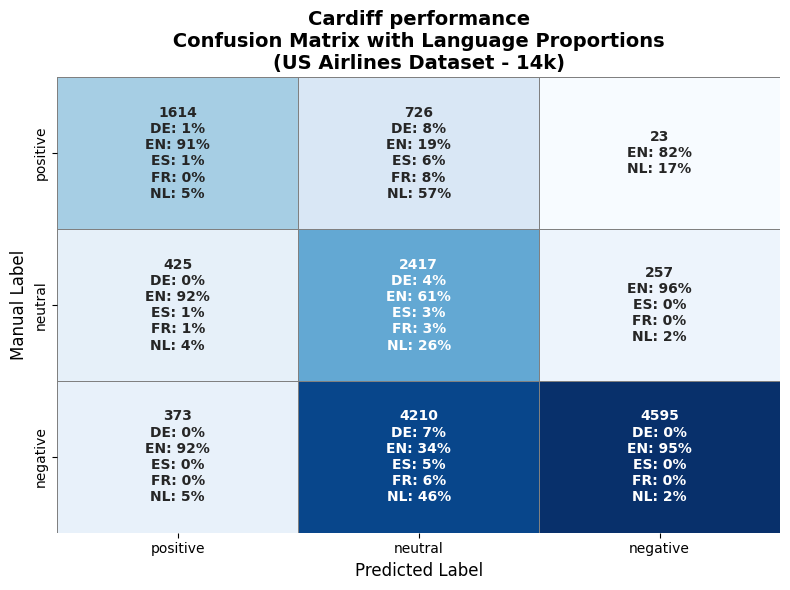

In [ ]:
### CARDIFF HEATMAP 1 ###
labels = ["positive", "neutral", "negative"]
plot_confusion_with_lang_partition(
    df_14k,
    true_col="manual_label",
    pred_col="pred_cardiff", 
    lang_col="target_lang",
    labels=labels,
    title="Cardiff performance\n Confusion Matrix with Language Proportions \n(US Airlines Dataset - 14k)"
)


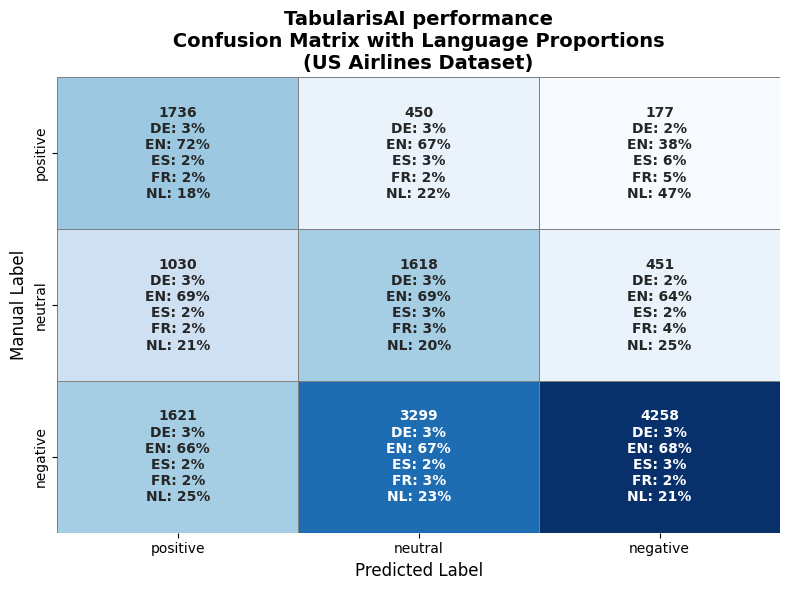

In [ ]:
labels = ["positive", "neutral", "negative"]
plot_confusion_with_lang_partition(
    df_14k,
    true_col= "manual_label",
    pred_col= "pred_tabularis",   
    lang_col="target_lang",
    labels=labels,
    title="TabularisAI performance\n Confusion Matrix with Language Proportions \n(US Airlines Dataset)"
)
